In [1]:
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# 로컬 소스코드 경로 등록
# 아래와 같이 경로 앞에 "src."를 붙여서 import
# from src.kebiml import ...

import sys
import os

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from sklearn.datasets import load_iris

# import some data to play with
iris = load_iris()
X = iris.data[:, :2]  # we only take the first two features. ['sepal length (cm)', 'sepal width (cm)']
y = iris.target

# 2 class 만들기
X_2cls = X[y > 0]
y_2cls = y[y > 0]
y_2cls -= 1

In [5]:
from src.kebiml.visutil.decision_boundary import decision_boundary_display_from_estimator

# 차트 도움 함수
cmap = plt.cm.rainbow_r

def scatter(X, y, ax, cmap=cmap):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors="k")
    
    labels = iris.target_names if y.max() > 1 else iris.target_names[-2:]
    ax.legend(scatter.legend_elements()[0], labels, loc="upper left")

def dbd(
    estimator,
    ax,
    title,
    plot_method="pcolormesh",
    response_method="auto",
    decision_normalize_method="sigmoid",
    multiclass_mix_rest=False,
    multiclass_target_index=None,
):
    ax.set_title(title)
    
    decision_boundary_display_from_estimator(
        estimator, X, ax=ax, cmap=cmap,
        plot_method=plot_method,
        response_method=response_method,
        decision_normalize_method=decision_normalize_method,
        multiclass_mix_rest=multiclass_mix_rest,
        multiclass_target_index=multiclass_target_index,
    )

    scatter(X, y, ax)

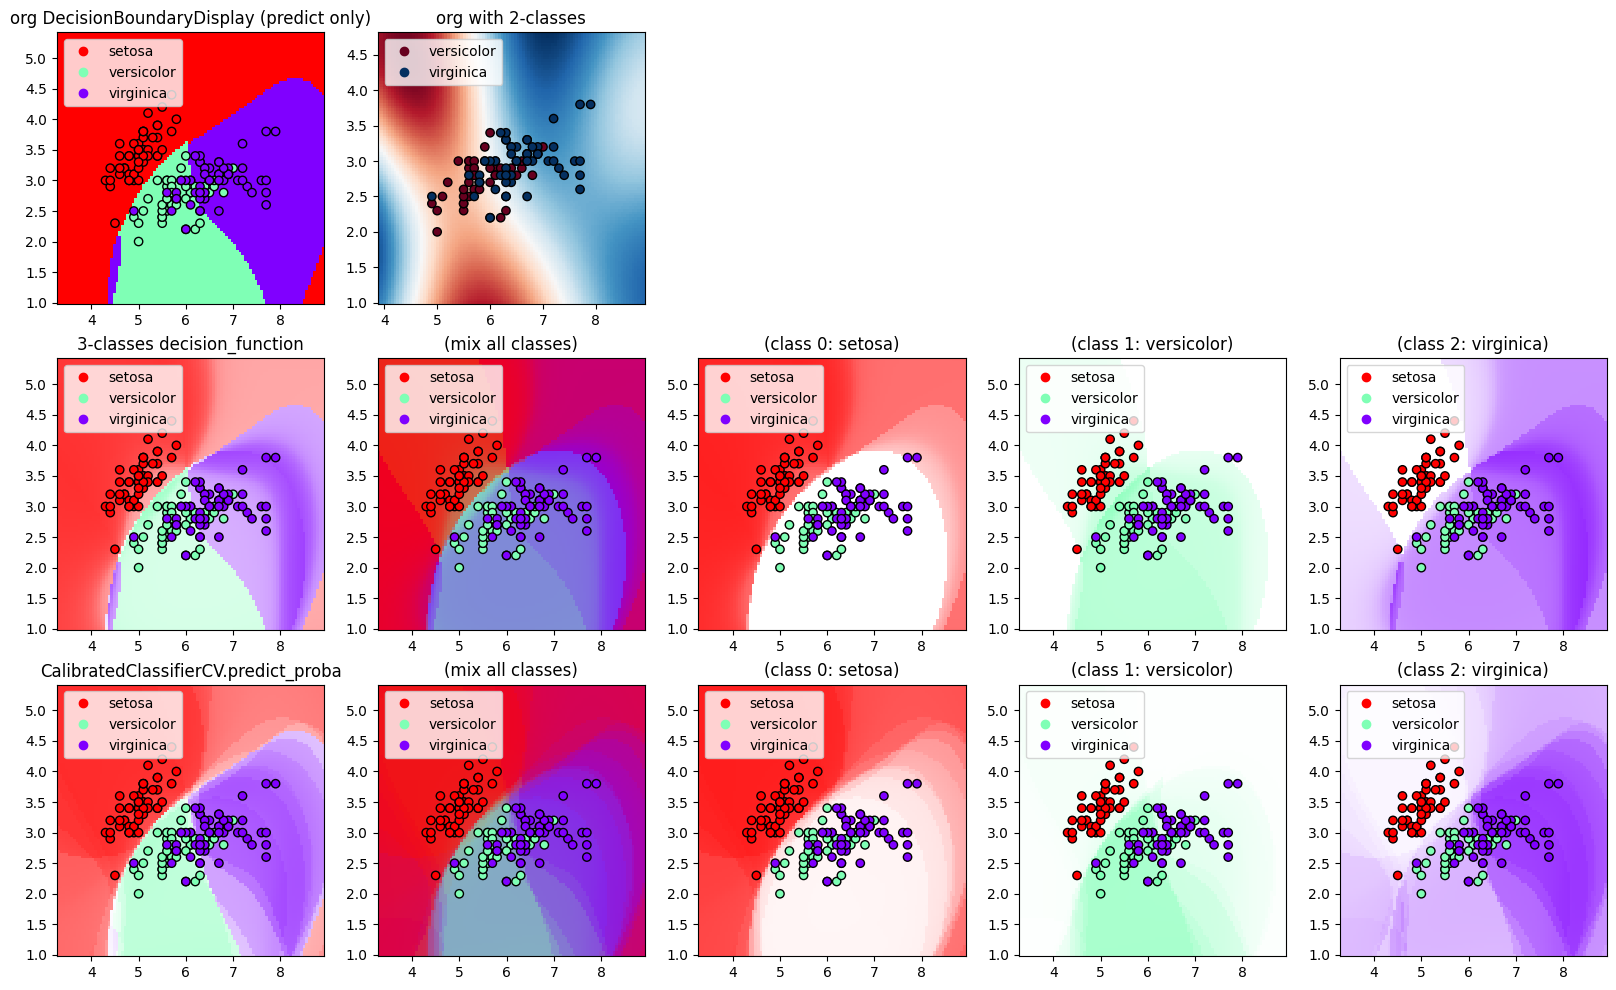

In [6]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import DecisionBoundaryDisplay

# 모델 학습
clf_2cls = SVC(C=100, gamma="scale")
clf_2cls.fit(X_2cls, y_2cls)

clf = SVC(C=100, gamma="scale")
clf.fit(X, y)

clf_calibrated = CalibratedClassifierCV(clf, cv=5)
clf_calibrated.fit(X, y)

# decision boundary display 비교
fig, axs = plt.subplots(3, 5, figsize=(20, 12))

# - 기존 DecisionBoundaryDisplay
axs[0, 0].set_title("org DecisionBoundaryDisplay (predict only)")
DecisionBoundaryDisplay.from_estimator(clf, X, plot_method="pcolormesh", ax=axs[0, 0], cmap=cmap)
scatter(X, y, axs[0, 0])

# - 기존 DecisionBoundaryDisplay w/ 2 classes
axs[0, 1].set_title("org with 2-classes")
DecisionBoundaryDisplay.from_estimator(clf_2cls, X_2cls, plot_method="pcolormesh", ax=axs[0, 1], cmap=plt.cm.RdBu)
scatter(X_2cls, y_2cls, axs[0, 1], cmap=plt.cm.RdBu)

# - 멀티클래스 decision_function 점수
dbd(clf, axs[1, 0], "3-classes decision_function")
# dbd(clf, axs[1, 0], "3-classes decision_function", decision_normalize_method="minmax")
dbd(clf, axs[1, 1], "(mix all classes)", multiclass_mix_rest=True)  # 예측 클래스와 더불어 나머지 클래스 색상도 혼합
dbd(clf, axs[1, 2], "(class 0: setosa)", multiclass_target_index=0)  # 클래스 0 점수
dbd(clf, axs[1, 3], "(class 1: versicolor)", multiclass_target_index=1)  # 클래스 1 점수
dbd(clf, axs[1, 4], "(class 2: virginica)", multiclass_target_index=2)  # 클래스 2 점수

# - 멀티클래스 CalibratedClassifierCV.predict_proba 확률
dbd(clf_calibrated, axs[2, 0], "CalibratedClassifierCV.predict_proba", response_method="predict_proba")
dbd(clf_calibrated, axs[2, 1], "(mix all classes)", response_method="predict_proba", multiclass_mix_rest=True)
dbd(clf_calibrated, axs[2, 2], "(class 0: setosa)", response_method="predict_proba", multiclass_target_index=0)
dbd(clf_calibrated, axs[2, 3], "(class 1: versicolor)", response_method="predict_proba", multiclass_target_index=1)
dbd(clf_calibrated, axs[2, 4], "(class 2: virginica)", response_method="predict_proba", multiclass_target_index=2)

for ax in axs.flat:
    if not ax.collections:
        ax.set_axis_off()

plt.show()